In [1]:
import os
import pandas as pd
from datetime import datetime

def phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold=0.7, window_size=250):
    if df[ramp_col].max() <= 15:
        return []

    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    if norm_df.empty:
        return []

    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    # Define dataframes for each phase
    phase1_df = df.iloc[:phase1_end + 1]
    phase2_df = df.iloc[phase1_end:phase2_end + 1]
    phase3_df = df.iloc[phase2_end + 1:]

    results = []
    for phase_df, phase_name in zip([phase1_df, phase2_df, phase3_df], ['Phase 1', 'Phase 2', 'Phase 3']):
        corr_series = phase_df[corr_col].iloc[window_size - 1:].dropna()
        total = len(corr_series)
        significant = (corr_series.abs() >= threshold).sum()
        contribution = (significant / total) if total > 0 else 0
        avg_corr = corr_series[abs(corr_series) >= threshold].abs().mean() if significant > 0 else 0

        results.append((phase_name, total, significant, contribution, avg_corr))
    return results


def process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250):
    df = pd.read_csv(file_path)
    coil_id = df['Coil ID'].iloc[0]
    all_results = []

    for signal in signal_features:
        for shape in shape_features:
            corr_col = f"{signal}_Rolling_Corr_{shape}"
            if corr_col not in df.columns:
                print(f"{corr_col} not in file")
                continue

            phase_stats = phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold, window_size)
            for phase_name, total, significant, contribution, avg_corr in phase_stats:
                all_results.append({
                    "Coil ID": coil_id,
                    "Phase": phase_name,
                    # "Coil Type": coil_type,
                    # "Grade": grade,
                    "Signal Feature": signal,
                    "Shape Feature": shape,
                    "Total Windows": total,
                    "Significant Correlation Window Count": significant,
                    "Contribution Factor %": f"{contribution * 100:.4f}",
                    "Average Correlation": avg_corr
                })

    return all_results


def process_folders_phasewise(base_folders, signal_features, shape_features, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250):
    all_results = []
    cnt = 0
    try:
        for folder in base_folders:
            print(folder)
            files = [f for f in os.listdir(folder) if f.endswith(".csv")]
            print(f"\nProcessing folder: {folder} | Files: {len(files)}")
            start_time = datetime.now()
    
            for file in files:
                cnt += 1
                print(f"{cnt}. {file}")
                file_path = os.path.join(folder, file)
                results = process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, ramp_col, threshold, window_size)
                all_results.extend(results)
    
            print(f"Finished folder: {folder} | Time taken: {datetime.now() - start_time}")
    except:
        pass
        
    final_df = pd.DataFrame(all_results)
    final_df["Contribution Factor %"] = final_df["Contribution Factor %"].astype(float)
    final_df = final_df[
    ((final_df['Phase'] == 'Phase 1') & (final_df['Contribution Factor %'] > 5)) |
    ((final_df['Phase'] == 'Phase 3') & (final_df['Contribution Factor %'] > 5)) |
    ((final_df['Phase'] == 'Phase 2') & (final_df['Contribution Factor %'] > 3))]
    
    # final_df = final_df[final_df["Contribution Factor %"] > 5]

    
    # final_output = "Phasewise_correlation_summary_1008GCQ_Good_Rework_Divert_Stand4Signals.csv"
    final_output = "Good_and_Bad_Coils_Phasewise_correlation_summary.csv"
    final_df.to_csv(final_output, index=False)
    print(f"\n All folders processed. Final summary saved to: {final_output}")


# === INPUT PARAMETERS ===

# signal_features = ['X4 Gauge Deviation',
#               'Master Ramp', 'Stand 1 Gap Operator Offset', 'Stand 2 Gap Operator Offset',
#                  'Stand 3 Gap Operator Offset', 'Stand 4 Gap Operator Offset', 'S1 Operating Bending Trim', 'S2 Operating Bending Trim',
#                  'S3 Operating Bending Trim', 'S4 Operating Bending Trim',
#                'X0 Gauge Deviation', 'X1 Gauge Deviation',
#                'Stand 1-2 Tension Reference', 'Stand 2-3 Tension Reference', 'Stand 3-4 Tension Reference', 'Stand 1-2 Total Tension Feedback',
#                  'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback', 'Exit Tension Reel Tension Reference',
#                  'Tension Reel Calculated Tension', 'Stand 1 Gap Bite Offset', 'Stand 1 Gap Stick Offset', 'Stand 1 Gap Thread Offset',
#                  'Stand 1 Thread Gap Setpoint', 'Stand 1 Run Gap Setpoint', 'Stand 2 Gap Bite Offset', 'Stand 2 Gap Stick Offset',
#                  'Stand 2 Gap Thread Offset', 'Stand 2 Thread Gap Setpoint', 'Stand 2 Run Gap Setpoint', 'Stand 3 Gap Bite Offset',
#                  'Stand 3 Gap Stick Offset', 'Stand 3 Gap Thread Offset', 'Stand 3 Thread Gap Setpoint', 'Stand 3 Run Gap Setpoint',
#                  'Stand 4 Gap Bite Offset', 'Stand 4 Gap Stick Offset', 'Stand 4 Gap Thread Offset', 'Stand 4 Thread Gap Setpoint',
#                  'Stand 4 Run Gap Setpoint', 'Stand 1 Predicted Run Force', 'Stand 2 Predicted Run Force', 'Stand 3 Predicted Run Force',
#                  'Stand 4 Predicted Run Force', 'Stand 1 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force',
#                  'Stand 1 Top Current Feedback', 'Stand 2 Top Current Feedback', 'Stand 3 Top Current Feedback', 'Stand 4 Top Current Feedback',
#                  'Stand 1 Bottom Current Feedback', 'Stand 2 Bottom Current Feedback', 'Stand 3 Bottom Current Feedback', 'Stand 4 Bottom Current Feedback',
#                  'Master Ramp', 'AGC GE Feedforward Hardness Number', 'AGC Alex Dynamic Feedforward Hardness Number', 'Stand 1 Total Bending Feedback',
#                  'Stand 2 Total Bending Feedback', 'Stand 3 Total Bending Feedback', 'Stand 4 OS Total Bending Feedback', 'Stand 4 DS Total Bending Feedback', 'Stand 1 - Operator Side Force', 
#                  'Stand 1 - Drive Side Force', 'Stand 2 - Operator Side Force', 'Stand 2 - Drive Side Force', 'Stand 3 - Operator Side Force',  'Stand 3 - Drive Side Force', 
#                  'Stand 4 - Operator Side Force', 'Stand 4 - Drive Side Force', 'Stand 1-2 Total Tension Feedback', 'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback',
#                  'Stand 1 Drive Speed Feedback', 'Stand 2 Drive Speed Feedback', 'Stand 3 Drive Speed Feedback', 'Stand 4 Drive Speed Feedback',
#                'Neet Oil Concentration', 'Stand 1-3 Solution Temperature', 'Stand 1-3 Solution System Pressure',
#                  'Stand 4 Solution System Pressure', 'Stand 1 Gap Eccentricity Trim', 'Stand 2 Gap Eccentricity Trim',
#                  'Stand 3 Gap Eccentricity Trim', 'Stand 4 Gap Eccentricity Trim', 'Morgoil OperBottom Bearing Outflow Temp Stand1',
#                  'Morgoil OperTop Bearing Outflow Temp Stand1', 'Morgoil DriveBottom Bearing Outflow Temp Stand1',
#                  'Morgoil DriveTop Bearing Outflow Temp Stand1', 'Morgoil OperBottom Bearing Outflow Temp Stand2',
#                  'Morgoil OperTop Bearing Outflow Temp Stand2', 'Morgoil DriveBottom Bearing Outflow Temp Stand2',
#                  'Morgoil DriveTop Bearing Outflow Temp Stand2', 'Morgoil OperBottom Bearing Outflow Temp Stand3',
#                  'Morgoil OperTop Bearing Outflow Temp Stand3', 'Morgoil DriveBottom Bearing Outflow Temp Stand3',
#                  'Morgoil DriveTop Bearing Outflow Temp Stand3', 'Morgoil OperBottom Bearing Outflow Temp Stand4',
#                  'Morgoil OperTop Bearing Outflow Temp Stand4', 'Morgoil DriveBottom Bearing Outflow Temp Stand4',
#                  'Morgoil DriveTop Bearing Outflow Temp Stand4']

signal_features = ['Master Ramp','Shape Target Second Coefficient', 'Stand 1 Predicted Run Force', 'Stand 1 Gap Stick Offset', 'Tension Reel Calculated Tension', 
                   'Tension To Gap 2 In Limit', 'Tension To Gap 2 In Force Limit', 'Gap Reset PB A4110_5', 'Stand 1-2 Total Tension Feedback', 'Ramp Greater Than Thread', 
                   'Stand 3 - Operator Side Force', 'Flatness Control - Bending In Limit', 'Stand 1 Run Gap Setpoint', 'Stand 1 Gap Bite Offset', 'S1 Operating Bending Trim', 
                   'Stand 2-3 Tension Reference', 'Stand 3 Predicted Run Force', 'Neet Oil Concentration', 'Morgoil DriveTop Bearing Outflow Temp Stand1', 'Stand 4 Top Current Feedback', 
                   'Morgoil DriveTop Bearing Outflow Temp Stand3', 'Stand 2-3 Total Tension Feedback', 'Stand 2 Predicted Run Force', 'Stand 4 Gap Thread Offset', 
                   'Stand 2 - Operator Side Force', 'Normal Stop LPB A4400_11', 'Stand 1 Gap Reset PB A4260_0', 'Stand 3 Run Gap Setpoint', 'Mill Hold A4000_9', 
                   'Stand 2 Total Bending Feedback', 'X0 Feedforward In Limit', 'Stand 2 Gap Bite Offset', 'Stand 4 AGC In Limit', 'Morgoil OperBottom Bearing Outflow Temp Stand3', 
                   'Exit Tension Reel Tension Reference', 'Stand 4 Thread Gap Setpoint', 'X4 Gauge Deviation', 'Stand 4 DS Total Bending Feedback', 'Stand 4 Gap Stick Offset', 
                   'Laser 0 Data Valid', 'Stand 4 - Operator Side Force', 'Stand 2 Gap Eccentricity Trim', 'Stand 4 Gap Operator Offset', 'Tension To Gap 3 In Force Limit', 
                   'Laser 1 Data Valid', 'Stand 3 Total Bending Feedback', 'X1 Feedback In Limit', 'Strip In Stand 3', 'Tension To Gap 4 In Force Limit', 'Morgoil OperTop Bearing Outflow Temp Stand1', 
                   'Strip In Stand 1', 'Stand 1 - Operator Side Force', 'SENIC (Tension to Speed 3) in Force Limit', 'X1 Gauge Deviation', 'Stand 3 Drive Speed Feedback', 'Stand 2 Gap Thread Offset', 
                   'Stand 4 Gap Bite Offset', 'Stand 2 Drive Speed Feedback', 'Normal Stop LPB A4500_11', 'Stand 3 Thread Gap Setpoint', 'Stand 1 Drive Speed Feedback', 
                   'Stand 1-3 Solution System Pressure', 'Morgoil OperBottom Bearing Outflow Temp Stand4', 'Tension To Speed 4 In Limit', 'Hold LPB A4400_9', 'Stand 2 Thread Gap Setpoint', 
                   'Stand 2 Top Current Feedback', 'Stand 1 AGC In Limit', 'Stand 1-3 Solution Temperature', 'Stand 4 - Drive Side Force', 'Stand 1 - Drive Side Force', 'Hold LPB A4300_9', 
                   'SENIC (Tension to Speed 3) in Limit', 'AGC GE Feedforward Hardness Number', 'Stand 1 Total Bending Feedback', 'Morgoil OperBottom Bearing Outflow Temp Stand1', 
                   'X1-SELECTED UNAVAILABLE (EVDA)', 'Stand 3 AGC In Limit', 'X0 Gauge Deviation', 'Morgoil DriveTop Bearing Outflow Temp Stand4', 'Gap Reset PB A4310_5', 
                   'Strip In Stand 4', 'Tension To Speed 1 In Limit', 'Stand 4 Predicted Run Force', 'Tension To Gap 3 In Limit', 'Stand 3 Bottom Current Feedback', 
                   'Stand 4 Gap Eccentricity Trim', 'Morgoil DriveBottom Bearing Outflow Temp Stand1', 'Stand 2 Gap Stick Offset', 'Stand 3-4 Tension Reference', 
                   'X0-SELECTED UNAVAILABLE (EVDA)', 'Stand 4 Bottom Current Feedback', 'Morgoil DriveTop Bearing Outflow Temp Stand2', 'Normal Stop LPB A4200_11', 
                   'Stand 1 Bottom Current Feedback', 'S3 Operating Bending Trim', 'Morgoil DriveBottom Bearing Outflow Temp Stand4', 'Stand 4 Drive Speed Feedback', 
                   'Stand 3 Gap Stick Offset', 'Morgoil OperTop Bearing Outflow Temp Stand4', 'Stand 3 Gap Thread Offset', 'Tension To Speed 2 In Limit', 
                   'Morgoil OperBottom Bearing Outflow Temp Stand2', 'Normal Stop LPB A4100_11', 'Stand 3-4 Total Tension Feedback', 'Morgoil OperTop Bearing Outflow Temp Stand2', 
                   'Stand 2 Gap Operator Offset', 'Stand 2 Bottom Current Feedback', 'Stand 2 - Total Force', 'Stand 4 Solution System Pressure', 'Stand 3 Gap Eccentricity Trim', 
                   'Stand 3 Gap Bite Offset', 'Stand 2 - Drive Side Force', 'Tension To Gap 4 In Limit', 'Stand 4 OS Total Bending Feedback', 'Normal Stop A5050_11', 
                   'Hold LPB A4200_9', 'Morgoil DriveBottom Bearing Outflow Temp Stand2', 'Stand 4 Run Gap Setpoint', 'Stand 1-2 Tension Reference', 'Hold LPB A4100_9', 
                   'Stand 2-4 Gap Reset PB A4260_2', 'X4-SELECTED UNAVAILABLE (EVDA)', 'Normal Stop LPB A4300_11', 'Gap Reset PB A4410_5', 'Stand 1 Gap Thread Offset', 
                   'Gap Reset PB Std 2 A4210_5', 'Stand 1 Gap Operator Offset', 'AGC Alex Dynamic Feedforward Hardness Number', 'Stand 3 - Drive Side Force', 'Stand 2 Run Gap Setpoint', 
                   'Stand 1 - Total Force', 'Hold LPB A4500_9', 'Stand 2 AGC In Limit', 'Stand 1 Thread Gap Setpoint', 'Stand 1 Top Current Feedback', 'Strip In Stand 2', 
                   'S4 Operating Bending Trim', 'Stand 1 Gap Eccentricity Trim', 'Stand 1 Control In Limit', 'Stand 3 Top Current Feedback', 
                   'Morgoil DriveBottom Bearing Outflow Temp Stand3', 'S2 Operating Bending Trim', 'Morgoil OperTop Bearing Outflow Temp Stand3', 'Stand 3 Gap Operator Offset',
                   "Stand 1 Backup RPM", "Stand 2 Backup RPM", "Stand 3 Backup RPM", "Stand 4 Backup RPM", "Stand 1 Top Motor RPM", "Stand 1 Bottom Motor RPM", "Stand 2 Top Motor RPM", 
                   "Stand 2 Bottom Motor RPM", "Stand 3 Top Motor RPM", "Stand 3 Bottom Motor RPM", "Stand 4 Top Motor RPM", "Stand 4 Bottom Motor RPM", "Payoff Reel OS RPM", 
                   "Payoff Reel DS RPM", "Exit Tension Reel RPM", "Roll Force Hydraulic Tank Level Inches", "Roll Force Hyd Tank Level Sensor Failure", "Roll Force Hyd Tank Level Too High", 
                   "Roll Force Hyd Tank Level Too Low", "Roll Force Hyd Tank Level Excessive Increase!", "Roll Force Hyd Tank Level Critical Loss!!!", "Stand 1 Roll Force Valve Stand Filter Dirty",
                   "Stand 2 Roll Force Valve Stand Filter Dirty", "Stand 3 Roll Force Valve Stand Filter Dirty", "Stand 4 Roll Force Valve Stand Filter Dirty","Stand 1 OS Roll Force", 
                   "Stand 2 OS Roll Force", "Stand 3 OS Roll Force", "Stand 4 OS Roll Force", "Stand 1 DS Roll Force", "Stand 2 DS Roll Force", "Stand 3 DS Roll Force", "Stand 4 DS Roll Force", 
                   "Roll Force Hydraulics Pressure Feedback", "Stand 1 Roll Force", "Stand 1 Roll Force limit (g67 delayed 200 ms + g80)", 
                   "Stand 1 Roll Force Increase Limit (based on predicted run force)",'Stand 4 OS Bending Shape Trim', 'Stand 4 DS Bending Shape Trim', 'Shape Target Second Coefficient']

shape_features = ["Operator_Q_VW_OLD_OPTECH","Q1_Q_VW_OLD_OPTECH","Center_Q_VW_OLD_OPTECH","Q2_Q_VW_OLD_OPTECH","Driver_Q_VW_OLD_OPTECH"]

coil_length_col = "Coil Length [30ms]"

# === RUN THE SCRIPT ===
base_folder = r"D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase"

process_folders_phasewise(
    base_folders=[base_folder],
    signal_features=signal_features,
    shape_features=shape_features,
    coil_length_col=coil_length_col
)


D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase

Processing folder: D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase | Files: 43
1. 5484972.csv
2. 5484981.csv
3. 5485581.csv
4. 5486250.csv
5. 5487008.csv
6. 5487932.csv
7. 5487937.csv
8. 5487948.csv
9. 5487949.csv
10. 5487951.csv
11. 5487953.csv
12. 5488171.csv
13. 5490707.csv
14. 5492525.csv
15. 5493226.csv
16. 5493229.csv
17. 5493231.csv
18. 5493809.csv
19. 5499278.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,12,14,33,35,42,46,47,49,50,51,53,55,66,70,75,79,80,84,85,87,93,104,116,125,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


20. 5499471.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


21. 5499642.csv
22. 5499738.csv
23. 5500841.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


24. 5503968.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


25. 5503973.csv
26. 5504079.csv
27. 5504094.csv
28. 5504098.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,12,14,33,35,42,46,47,49,50,51,53,55,66,70,75,79,80,84,85,87,93,104,116,125,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


29. 5504100.csv
30. 5510195.csv
31. 5512575.csv
32. 5513807.csv
33. 5514668.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


34. 5514670.csv
35. 5514672.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


36. 5514674.csv
37. 5514677.csv
38. 5514681.csv
39. 5519376.csv
40. 5519680.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


41. 5520680.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


42. 5520684.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


43. 5522770.csv


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13728\1506842455.py:35: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142,165,166,167,168,169,170,171,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Finished folder: D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase | Time taken: 0:18:26.523687

 All folders processed. Final summary saved to: Good_and_Bad_Coils_Phasewise_correlation_summary.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def generate_heatmap(df, grade, shape_features_to_include=None):
    # Step 1: Count total unique coils
    total_unique_coils = df['Coil ID'].nunique()
    print(f"Total coils of grade {grade} : {total_unique_coils}")
    
    # Step 2: Filter rows with contribution above 5%
    df = df[
    ((df['Phase'] == 'Phase 1') & (df['Contribution Factor %'] > 5)) |
    ((df['Phase'] == 'Phase 3') & (df['Contribution Factor %'] > 5)) |
    ((df['Phase'] == 'Phase 2') & (df['Contribution Factor %'] > 3))]
    total_unique_coils = df['Coil ID'].nunique()
    print(f"Total coils of grade {grade} showing contribution above threshold : {total_unique_coils}")

    for phase in df["Phase"].unique():
        if(phase == 'Phase 2'):
            prcnt = 3
        else:
            prcnt = 5
        phase_df = df[df["Phase"] == phase]
        total_unique_coils = phase_df['Coil ID'].nunique()
        print(f"Total coils of grade {grade} showing contribution above {prcnt}% in {phase} : {total_unique_coils}")
    
        # Step 3: Count unique Coil IDs for each Signal-Shape pair
        grouped = phase_df.groupby(['Signal Feature', 'Shape Feature'])['Coil ID'].nunique().reset_index()

        # Optional: filter to include only selected Shape Features
        if shape_features_to_include:
            grouped = grouped[grouped['Shape Feature'].isin(shape_features_to_include)]
        
        # Step 4: Calculate percentage
        grouped['Percentage'] = (grouped['Coil ID'] / total_unique_coils) * 100
        
        # Step 5: Pivot for heatmap
        heatmap_data = grouped.pivot(index='Signal Feature', columns='Shape Feature', values='Percentage').fillna(0)
        
        plt.figure(figsize=(11, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% of Unique Coils'})
        plt.title(f'Heatmap of % Unique Coils per Signal-Shape Feature Combination | {phase} | {grade}')
        plt.xlabel('Shape Features')
        plt.ylabel('Signal Features')
        plt.tight_layout()
        plt.savefig(f"heatmap_percentage_{phase}.png", dpi=300)
        plt.show()

Total coils of grade 1008GCQ : 2265
Total coils of grade 1008GCQ showing contribution above threshold : 2265
Total coils of grade 1008GCQ showing contribution above 5% in Phase 1 : 938


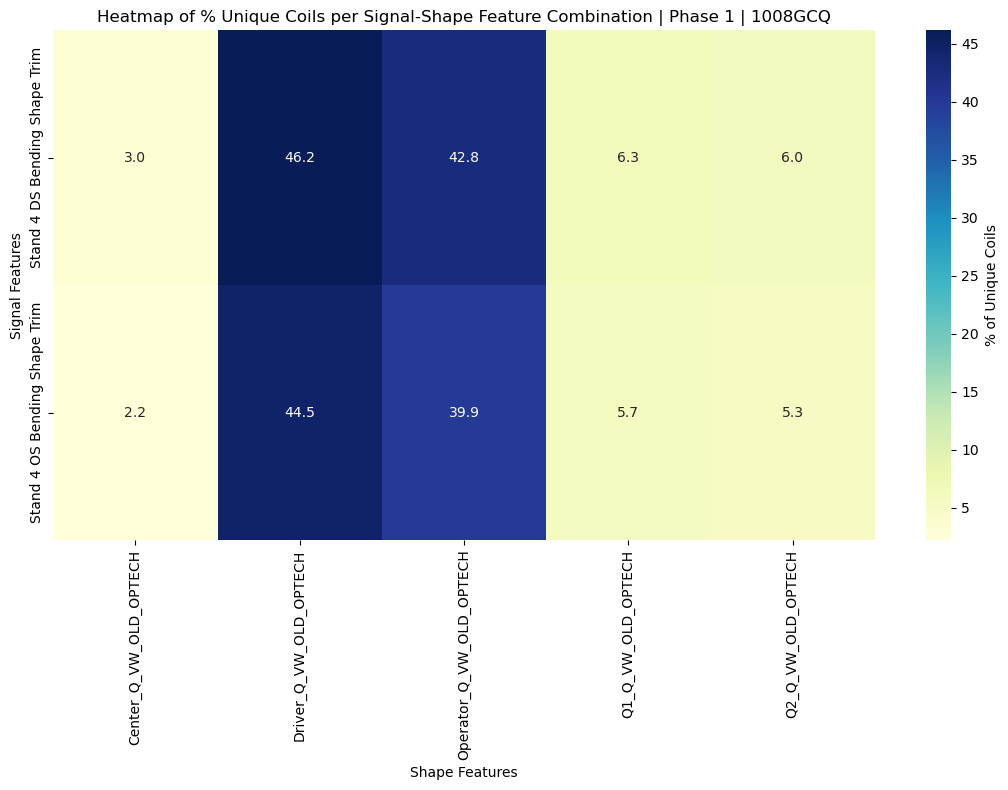

Total coils of grade 1008GCQ showing contribution above 5% in Phase 3 : 1789


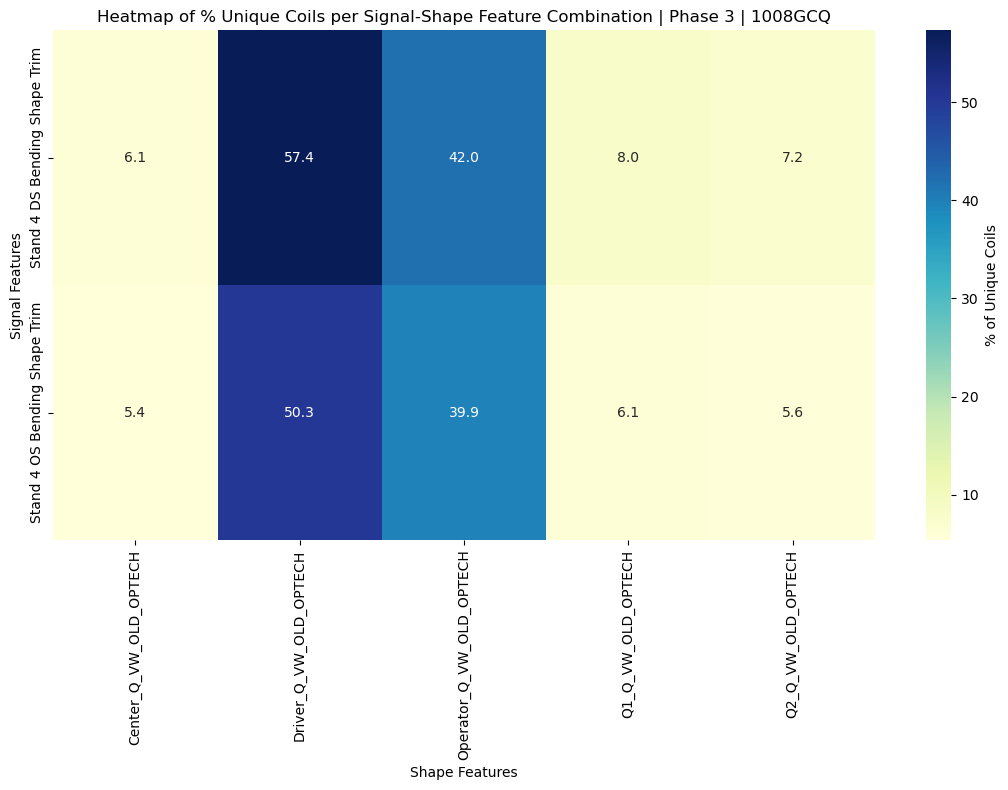

Total coils of grade 1008GCQ showing contribution above 3% in Phase 2 : 721


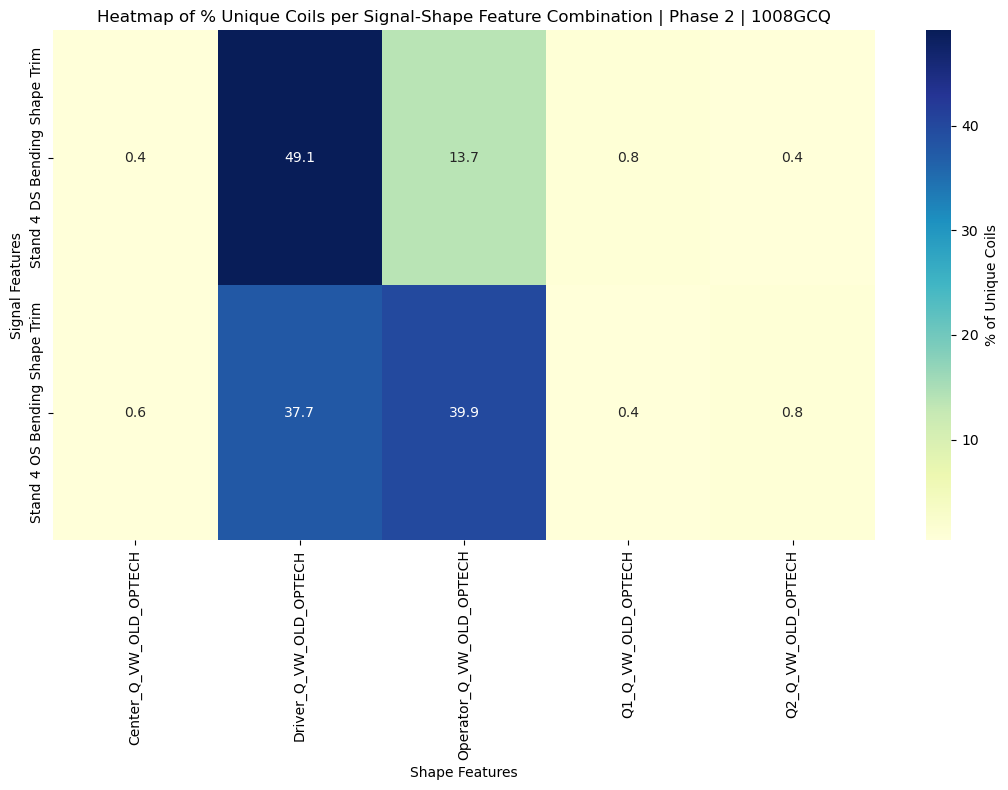

In [3]:
df = pd.read_csv("Amiy_newcolumns_Phasewise_correlation_summary.csv")
generate_heatmap(df, "1008GCQ",shape_features)